In [172]:
import serial.tools.list_ports

# List all available serial ports
ports = serial.tools.list_ports.comports()
for port, desc, hwid in sorted(ports):
    print(f"{port}: {desc} [{hwid}]")

/dev/cu.Bluetooth-Incoming-Port: n/a [n/a]
/dev/cu.JBLGO: n/a [n/a]


In [82]:
import serial
import time
import serial.tools.list_ports

# List all available serial ports for debugging
ports = serial.tools.list_ports.comports()
print("Available serial ports:")
for port, desc, hwid in sorted(ports):
    print(f"{port}: {desc} [{hwid}]")

# Configure the serial port
serial_port = '/dev/cu.usbmodem154668601'  # Update this to your serial port
baud_rate = 460800  # Update to match the baud rate of your Teensy
output_file = 'tttt.txt'

try:
    # Open the serial port
    ser = serial.Serial(serial_port, baud_rate, timeout=1)
    time.sleep(2)  # Give some time for the serial connection to establish

    # Open the file in write mode
    with open(output_file, 'w') as file:
        print(f"Collecting data from {serial_port}...")
        try:
            while True:
                if ser.in_waiting > 0:
                    line = ser.readline().decode('utf-8').strip()
                    if line:
                        #print(f"Read line: {line}")
                        file.write(line + '\n')
                        file.flush()  # Ensure data is written to the file
                else:
                    print("No data available in the buffer.")
                    time.sleep(0.1)  # Small delay to prevent CPU overload
        except KeyboardInterrupt:
            print("Data collection stopped.")
        finally:
            ser.close()
            print(f"Data saved to {output_file}.")
except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")


Available serial ports:
/dev/cu.Bluetooth-Incoming-Port: n/a [n/a]
/dev/cu.JBLGO: n/a [n/a]
/dev/cu.usbmodem154668601: USB Serial [USB VID:PID=16C0:0483 SER=15466860 LOCATION=2-1.4]
No data available in the buffer.
Data collection stopped.
Data saved to tttt.txt.


In [105]:
import numpy as np

# Function to read the text file and store the numbers in a numpy array
def read_numbers_from_file(file_path):
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()
        # Convert the lines to a list of integers
        numbers = [int(line.strip()) for line in lines]
    # Convert the list to a numpy array
    numbers_array = np.array(numbers)
    return numbers_array

# Specify the path to your text file
file_path = '/Users/jc/Desktop/PHYS 115B/caonimadebi222.txt'
# Call the function and store the result in a variable
numbers_array = read_numbers_from_file(file_path)

# Print the numpy array
print(numbers_array)


[   0    0    8 ... 2633 2642 2641]


In [68]:
from matplotlib import pyplot as plt


In [135]:
np.arange(1,2)

array([1])

(0.0, 3.3)

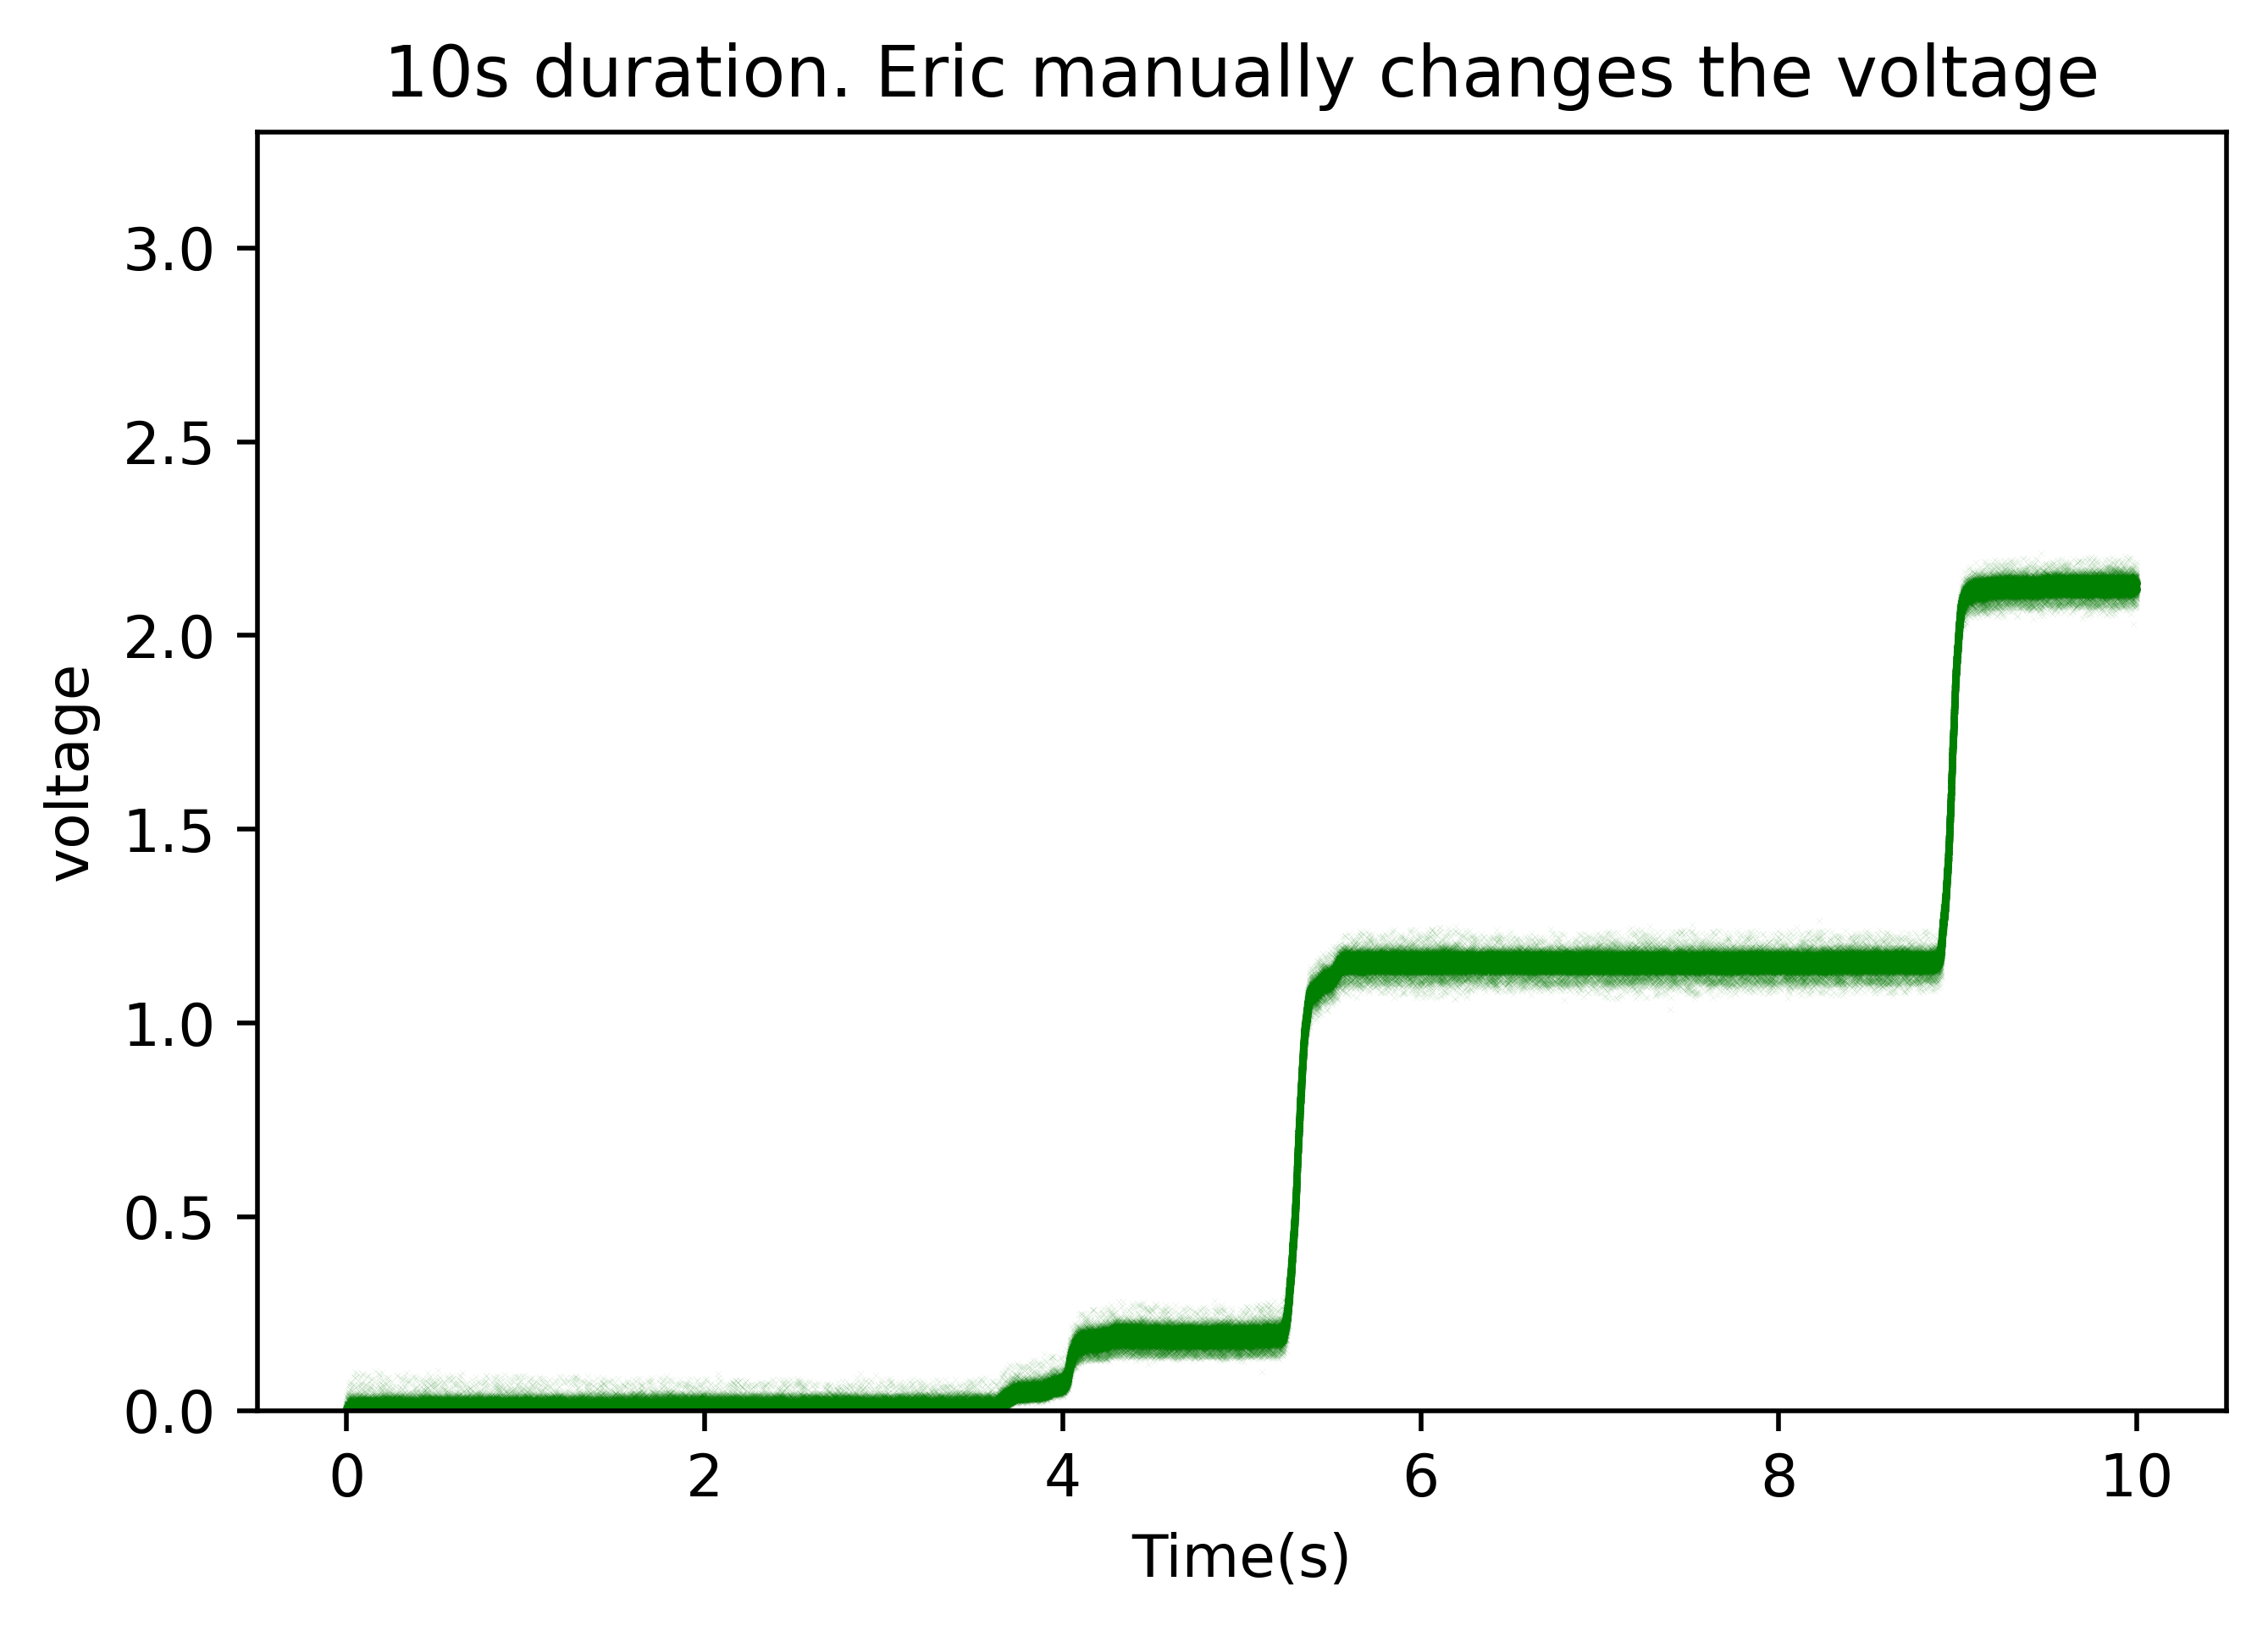

In [141]:
plt.figure(dpi=500)
plt.scatter(np.arange(0,len(numbers_array))*q,numbers_array*3.3/2**12,s=0.001,alpha=0.2,color="green",marker="x")
plt.xlabel("Time(s)")
plt.ylabel("voltage")
plt.title("10s duration. Eric manually changes the voltage")
plt.ylim(0,3.3/2**12*4096)

In [128]:
q=10/len(numbers_array)
q

4.3020707587390116e-06

In [124]:
1/q 

232446.19999999998

In [116]:
print(f"the standrad deviation within range 1.5 to 2 is {np.std(numbers_array[int(1.5e6):int(1.8e6)])} \n the mean is {np.average(numbers_array[int(1.5e6):int(1.8e6)])},\n this maps to the true voltage of {3.3/2**12*np.average(numbers_array[int(1.5e6):int(1.8e6)])}V")

the standrad deviation within range 1.5 to 2 is 9.79400012032537 
 the mean is 1432.65458,
 this maps to the true voltage of 1.1542383090820312V


(0.0, 4096.0)

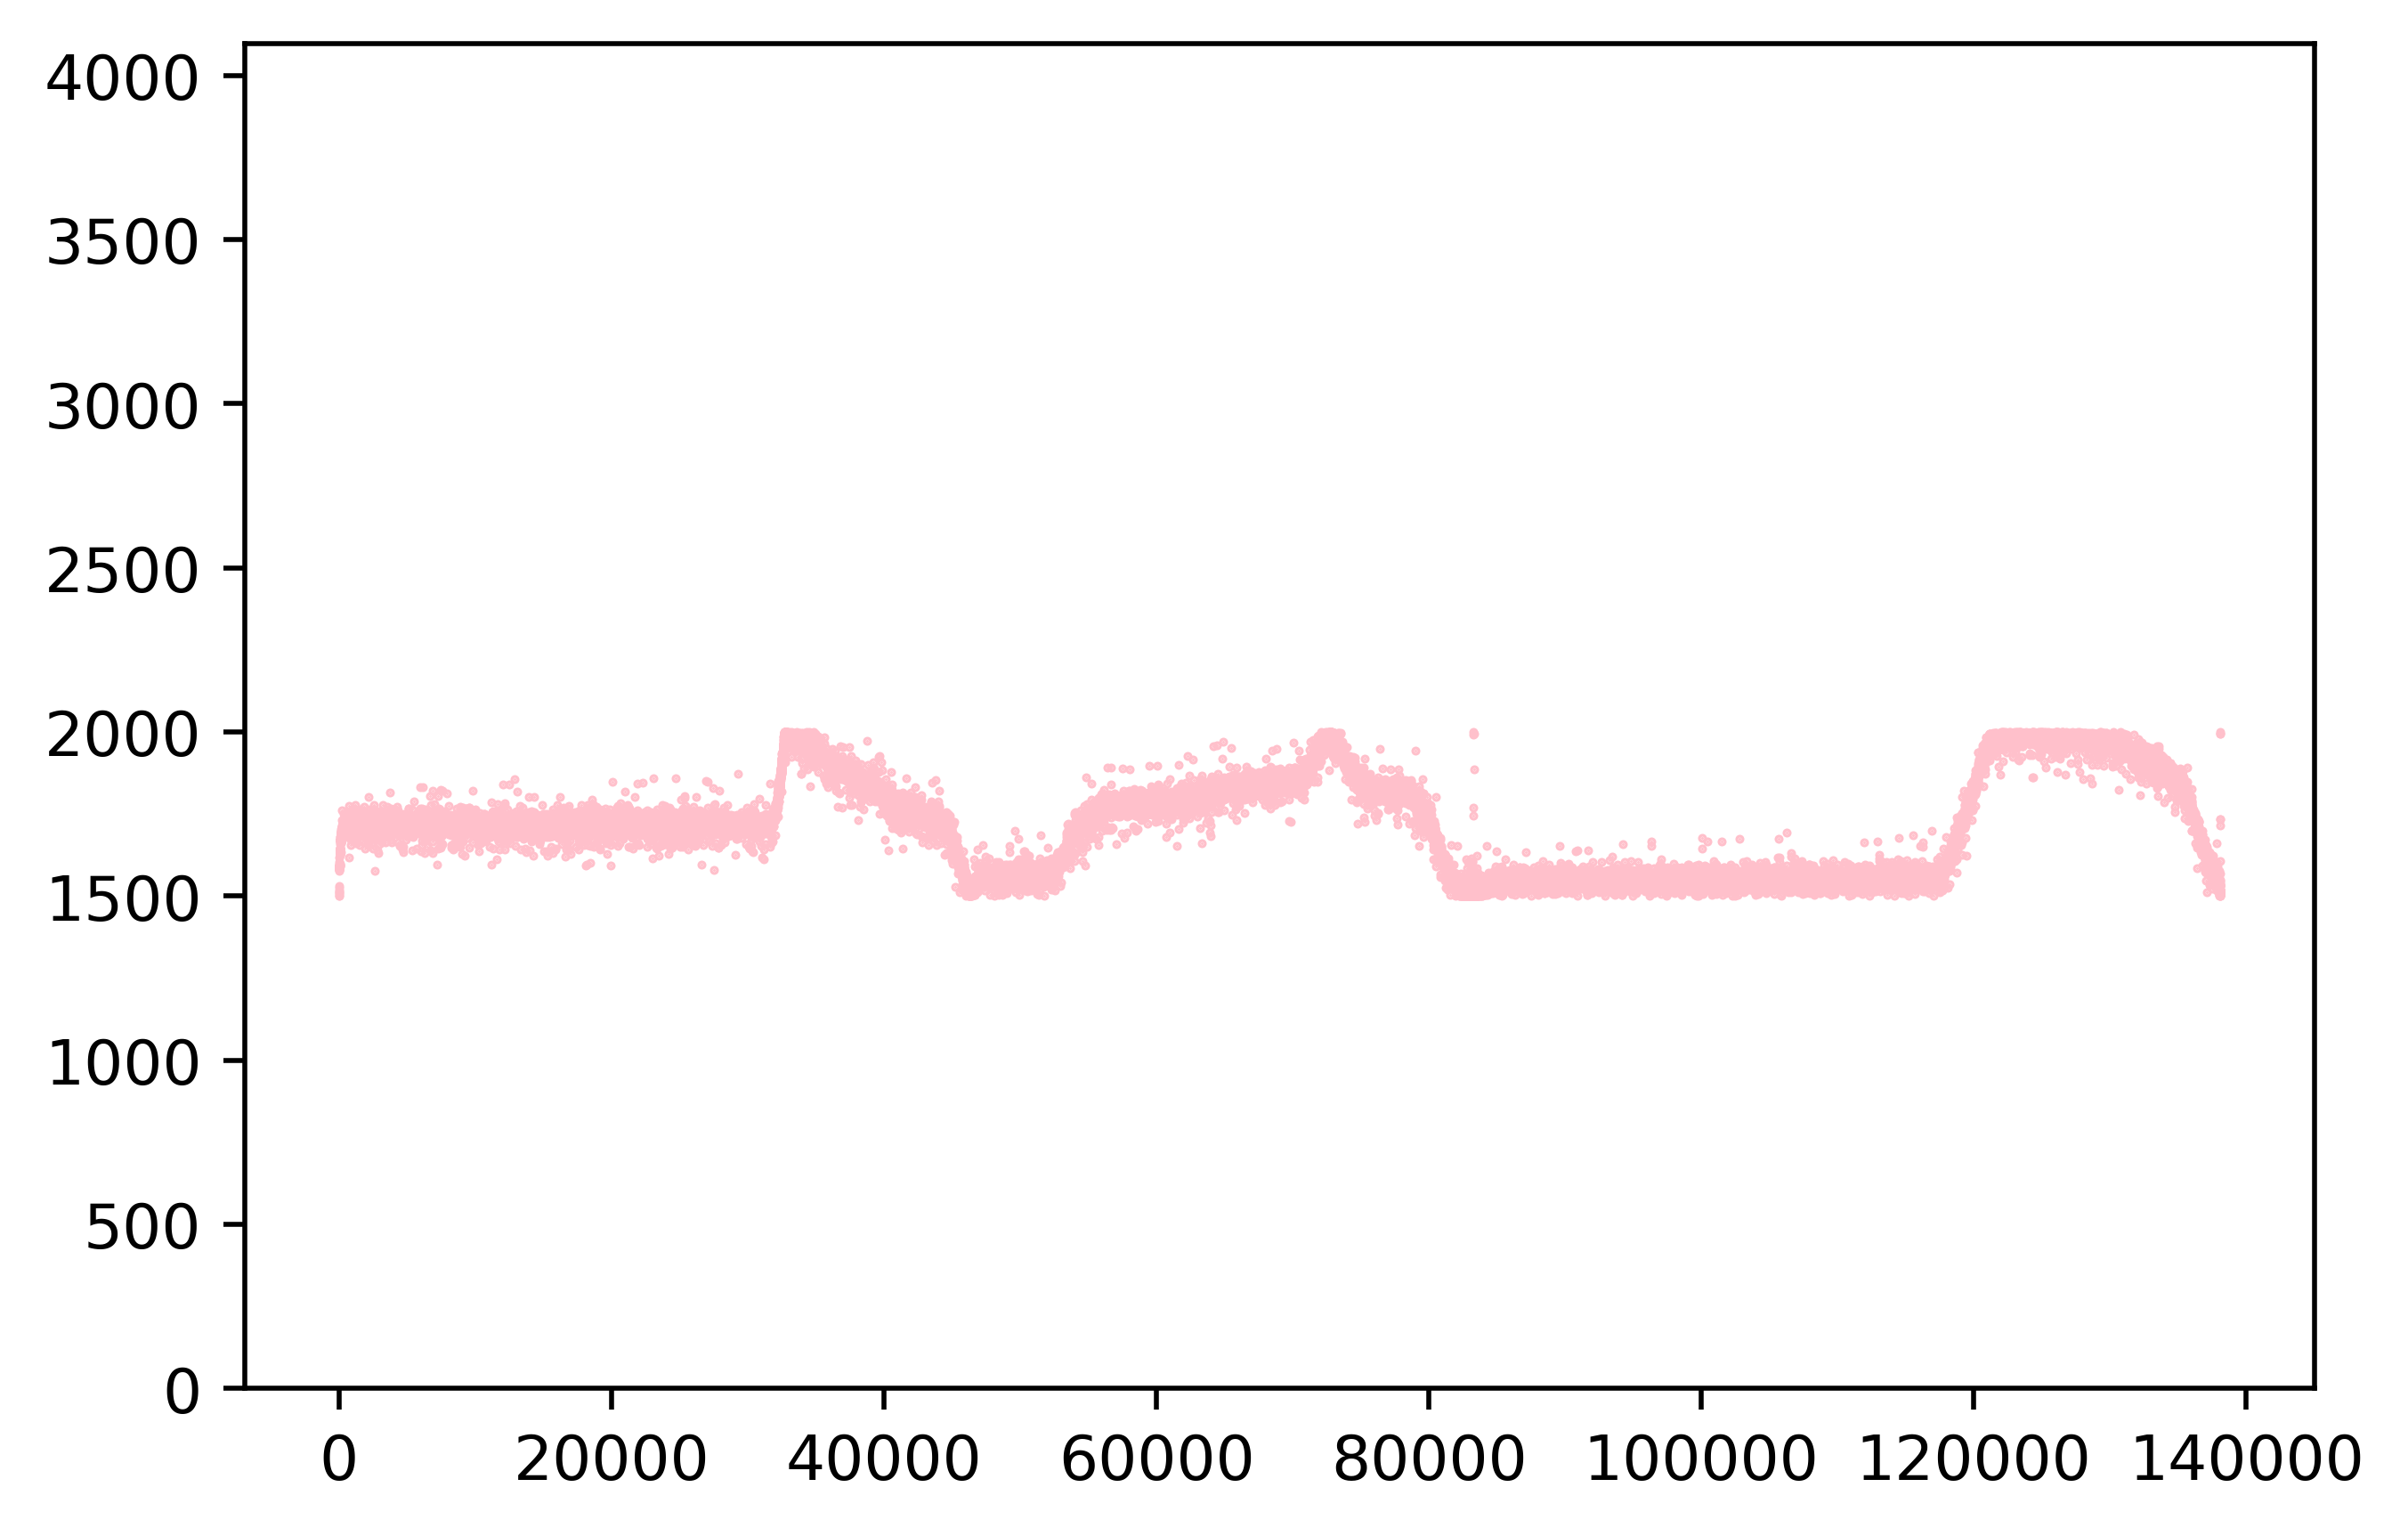

In [91]:
plt.figure(dpi=500)
plt.scatter(range(len(selected_elements)),selected_elements,s=0.2,color="pink")
plt.ylim(0,4096)

In [161]:
import serial
import threading
import time
import os

# Fast serial readline implementation
class ReadLine:
    def __init__(self, s):
        self.buf = bytearray()
        self.s = s

    def readline(self):
        i = self.buf.find(b"\n")
        if i >= 0:
            r = self.buf[:i + 1]
            self.buf = self.buf[i + 1:]
            return r
        while True:
            i = max(1, min(2048, self.s.in_waiting))
            data = self.s.read(i)
            i = data.find(b"\n")
            if i >= 0:
                r = self.buf + data[:i + 1]
                self.buf[0:] = data[i + 1:]
                return r
            else:
                self.buf.extend(data)

# Serial reading thread for 10 seconds
class SerialReader(threading.Thread):
    def __init__(self, port, baud, duration=10, output_file="output.txt"):
        super(SerialReader, self).__init__()
        self.port = port
        self.baud = baud
        self.duration = duration
        self.output_file = output_file
        self.data = []
        self._stop = threading.Event()
        os.makedirs(os.path.dirname(self.output_file), exist_ok=True)

    def stop(self):
        self._stop.set()

    def stopped(self):
        return self._stop.is_set()

    def run(self):
        try:
            with serial.Serial(self.port, self.baud, timeout=0.5, rtscts=True) as com:
                rl = ReadLine(com)
                start_time = time.time()
                while time.time() - start_time < self.duration:
                    if self.stopped():
                        break
                    while com.in_waiting:
                        line = rl.readline()
                        if line:
                            self.data.append(line.decode('utf-8').strip())
                self.save_data()
        except Exception as e:
            print("\nSERIAL PORT ERROR:", e)
            return

    def save_data(self):
        with open(self.output_file, "w") as f:
            f.write("\n".join(self.data))
        print(f"Data saved to {self.output_file}")

# Function to start reading from the serial port
def read_from_serial(port, baud, duration=10, output_file="output/output.txt"):
    reader = SerialReader(port, baud, duration, output_file)
    reader.start()
    reader.join()

# Example usage
if __name__ == "__main__":
    port = "/dev/cu.usbmodem154668601"  # Your specific port
    baud = 115200  # Replace with your baud rate
    duration = 10  # Duration in seconds
    output_file = "/Users/jc/Desktop/PHYS 115B/caonimadebi555.txt"  # Output file path

    read_from_serial(port, baud, duration, output_file)



SERIAL PORT ERROR: [Errno 2] could not open port /dev/cu.usbmodem154668601: [Errno 2] No such file or directory: '/dev/cu.usbmodem154668601'


TypeError: 'Event' object is not callable

In [160]:
import numpy as np

# Function to read the text file and store the numbers in a numpy array
def read_numbers_from_file(file_path):
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()
        # Convert the lines to a list of integers
        numbers = [int(line.strip()) for line in lines]
    # Convert the list to a numpy array
    numbers_array = np.array(numbers)
    return numbers_array

# Specify the path to your text file
file_path = '/Users/jc/Desktop/PHYS 115B/caonimadebi444.txt'
# Call the function and store the result in a variable
numbers_array2 = read_numbers_from_file(file_path)

# Print the numpy array
print(numbers_array2)


[1860 1857 1856 ...   70   71   67]


In [153]:
jj = 10/len(numbers_array2)
jj

5.140671916663539e-06

In [146]:
max(numbers_array2)

657

In [147]:
3.3/1024*657

2.11728515625